In [1]:
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from scipy.interpolate import interpn

import nibabel
import sys

#sys.path.append("/Users/vchaplin/Documents/hifu/code/myPy/")

import imagemanip
#sys.path.append("/Users/vchaplin/Documents/hifu_repos/fus_igt/py/")

from Geometry import quaternion
from mpl_toolkits.mplot3d import Axes3D

import FUSTrackedUtils

In [2]:
%matplotlib notebook

In [13]:
ct = nibabel.load("/media/caskeylab/DATAPART1/Data/monkey_skullpiece_ct/reduced/monkey_skullpiece_ct_reduced.nii")

ctvox = ct.get_data().squeeze()

(dx,dy,dz,junk) = ct.header.get_zooms()

(N0,N1,N2) = ctvox.shape

v0 = np.arange(0,ctvox.shape[0]+1)
v1 = np.arange(0,ctvox.shape[1]+1)
v2 = np.arange(0,ctvox.shape[2]+1)

mult = 5

dd = np.sqrt(np.sum( np.array(np.meshgrid(np.arange(N0) - N0/2.0, np.arange(N1)- N1/2.0, np.zeros(N2), indexing='ij'))**2, axis = 0))

circvox = np.logical_and(dd > 225, dd<255)

ctvox[circvox]=0

(ctred,(M00,M11,M22)) = imagemanip.NDrebin(ctvox,[v0,v1,v2], [ np.arange(0,N0,mult), np.arange(0,N1,mult), np.arange(0,N2,mult)] )

dx*=mult
dy*=mult
dz*=mult

In [17]:
def isodd(x):
    return np.mod(x,2)==1

def constrain(xi,yi,zi):
    
    return ctred[np.ix_(xi,yi,zi)] > 1000

def relocate(array,locator):
    return [array[locator[0]], array[locator[1]], array[locator[2]]]
def diagonaly_index(array1, indexarr):
    return [array1[0][indexarr[0]], array1[1][indexarr[1]], array1[2][indexarr[2]]] 

def create_raster_path(xp, yp, zp, order=(0,1,2), constraint=None):

    axp = [xp,yp,zp]
    dims = list(map(len,axp))

    locator=[0,0,0]
    for oi in range(3):
        locator[order[oi]] = oi

    iter2 = range(dims[order[2]])

    xyzvecs=[]
    indvecs=[]

    dims.append(3)
    orientation = np.zeros(dims,dtype=int)
    
    print(locator)
    

    for i2 in iter2:
        if isodd(i2):
            iter1 = range(dims[order[1]]-1,-1,-1)
            dir1=-1
        else:
            iter1 = range(0, dims[order[1]])
            dir1=1
            
        

        for i1 in iter1:
            if isodd(i1+i2):
                
                iter0 = range(dims[order[0]]-1,-1,-1)
                dir0=-1
            else:
                iter0 = range(0,dims[order[0]])
                dir0=1
            
            if constraint is not None:
                points = diagonaly_index( axp, relocate([iter0,[i1],[i2]], locator) )
                conflicts0 = np.where( constrain(*tuple( points ) ).squeeze() )[0]
            
                #print(iter0,i1,i2, np.sum( points) )

                if len(conflicts0) > 0:
                    if isodd(i1+i2):
                        iter0 = iter0[(conflicts0[-1]+1):]
                    else:
                        iter0 = iter0[0:conflicts0[0]]
                    #print(conflicts0)

            for i0 in iter0:
                u = [i0,i1,i2]
                vec = relocate(u, locator)
                xyzvecs.append( diagonaly_index(axp,vec)  )
                indvecs.append(vec)

                step = [dir0, 0, 0]            
                orientation[vec[0],vec[1],vec[2]] = [step[locator[0]], step[locator[1]], step[locator[2]]]

            step = [0, dir1, 0]            
            orientation[vec[0],vec[1],vec[2]] = [step[locator[0]], step[locator[1]], step[locator[2]]]

        step = [0, 0, 1]            
        orientation[vec[0],vec[1],vec[2]] = [step[locator[0]], step[locator[1]], step[locator[2]]]


    xyzvecs = np.array(xyzvecs)
    indvecs = np.array(indvecs)
    return (xyzvecs, indvecs, orientation)

In [74]:
xp = np.arange(30,70,2)
yp = np.arange(30,80, 2)
zp = np.arange(20,71, 5)

(nx,ny,nz) = list(map(len,[xp,yp,zp]))


In [75]:
xyzvecs_uncon, junk, junk = create_raster_path(xp,yp,zp, order=(1,0,2), constraint=None)

xyzvecs, ijkvecs, stepdir = create_raster_path(xp,yp,zp, order=(1,0,2), constraint=constrain)

print(len(xyzvecs))

[1, 0, 2]
[1, 0, 2]
4209


In [76]:
v0 = np.arange(0,ctred.shape[0])
v1 = np.arange(0,ctred.shape[1])
v2 = np.arange(0,ctred.shape[2])

pathInterp = interpn((v0,v1,v2),ctred, xyzvecs_uncon, bounds_error=False, fill_value=-1)


crossing = pathInterp > 5000

<IPython.core.display.Javascript object>


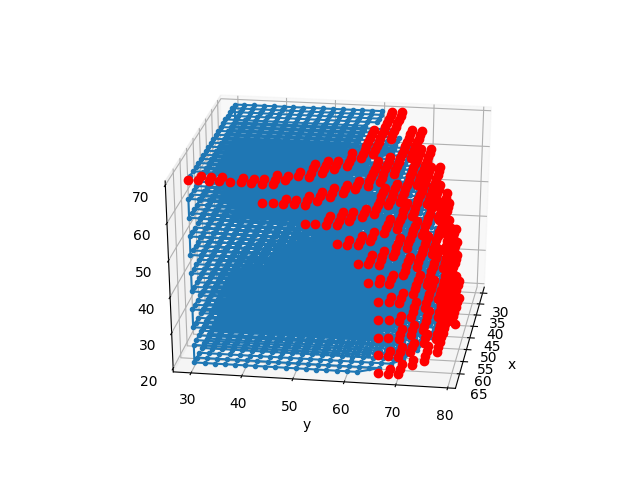

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.plot( xyzvecs[:,0], xyzvecs[:,1], xyzvecs[:,2], '.-')
#plt.plot( xyzvecs_uncon[:,0], xyzvecs_uncon[:,1], xyzvecs_uncon[:,2], '--k')
plt.plot( xyzvecs_uncon[crossing,0], xyzvecs_uncon[crossing,1], xyzvecs_uncon[crossing,2], 'ro')
plt.xlabel('x')
plt.ylabel('y')

<IPython.core.display.Javascript object>


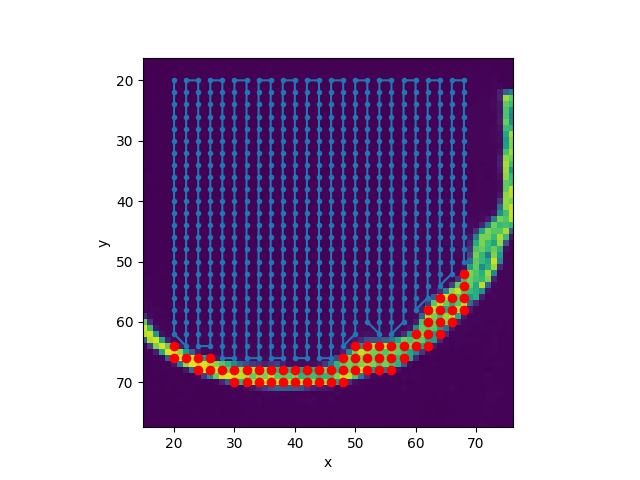

In [52]:
plt.plot( xyzvecs[:,0], xyzvecs[:,1], '.-')
#plt.plot( xyzvecs_uncon[:,0], xyzvecs_uncon[:,1], xyzvecs_uncon[:,2], '--k')
plt.plot( xyzvecs_uncon[crossing,0], xyzvecs_uncon[crossing,1], 'ro')
plt.imshow(ctred[:,:,60].T)
plt.xlabel('x')
plt.ylabel('y')

<IPython.core.display.Javascript object>


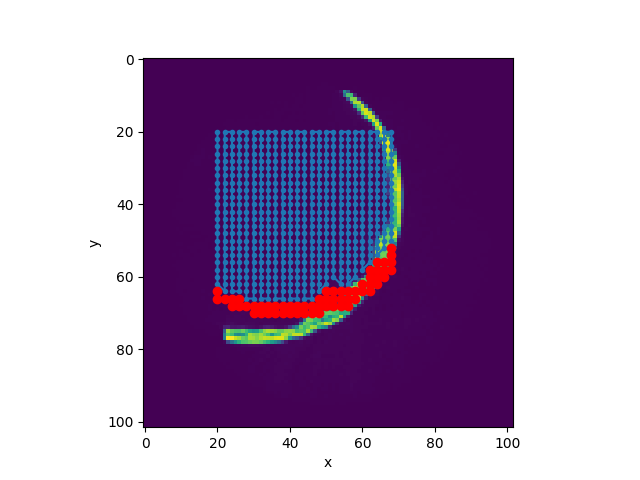

In [28]:
plt.imshow(ctred[:,:,60])

In [334]:
constrain([30], range(100,20,-1),[60] ).squeeze()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False], dtype=bool)